# Cose da fare

1. One_vs_all classification con keras (FATTO)

2. Raggruppare un po' di feature che appaiono poche volte nella voce "altro"

3. AUTOML

4. Feature selection (FORSE)








In [0]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 2.8MB/s 


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier


from xgboost.sklearn import XGBClassifier
import xgboost

from keras import models, layers, optimizers, metrics, callbacks


from keras.wrappers.scikit_learn import KerasClassifier
import collections

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Funzioni per calcolare ndcg

def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) ))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)



ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [0]:
# Funzione per standardizzare
def standardize(data, columns):
    for i in columns:
        data[i] = (data[i] - data[i].mean()) / data[i].std()
    return data

In [0]:
def remove_rare_values_inplace(df_frame, column_list, threshold):
    """ Remove rare values to speed up computation.
    Args:
        df_frame -- A pandas data frame.
        column_list -- A list of columns.
        threshold -- The threshold, below which a value is removed.
    """
    insignificant_population = int(np.floor(threshold * len(df_frame)))
    for cat in column_list:
        freqs = collections.Counter(df_frame[cat])
        other = [i for i in freqs if freqs[i] < insignificant_population]
        for i in other:
            df_frame[cat].replace(i, 'other', inplace=True)

# Load Data

In [0]:
data = pd.read_csv('/content/drive/My Drive/progetto_aml/dataset/train_users_2.csv')
#test = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/test_users.csv")
sessions = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/sessions.csv")
#age_gender = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/age_gender_bkts.csv")

In [0]:
data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [0]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


# Preprocess

In [0]:
# Scartiamo la feature "date_first_booking" inutile

data.drop("date_first_booking", axis = 1, inplace = True)

## Classe obiettivo

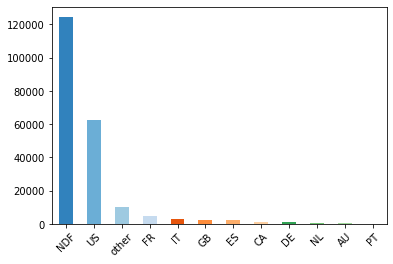

In [0]:
data.country_destination.value_counts().plot(kind='bar', rot = 45,color=plt.cm.tab20c(np.arange(len(data.country_destination.unique()))))
plt.show()

# Classe obietivo è sbilanciata, la maggior parte degli utenti non prenotatimestamp_first_active

## Age

In [0]:
data["age"].describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [0]:
data["age"].value_counts(ascending=False, dropna=False)

NaN       116866
30.0        7712
28.0        7687
29.0        7647
31.0        7540
           ...  
1941.0         1
1942.0         1
150.0          1
1948.0         1
1952.0         1
Name: age, Length: 146, dtype: int64

Ci sono persone iscritte con meno di 18 anni, il cui va contre le regole di Airbnb, e persone che superano di granlunga i 100 anni.

Alcuni user probabilmente hanno inserito l'anno di nascita (es. 1990) altri potrebbero essere errori o non volontà di comunicare la vera età (es. 230).

In [0]:
# Si prova a sistemare gli user che hanno inserito l'anno di nascita (il dataset risale al 2015)

user_with_year_age_mask = data['age'] > 1000
data.loc[user_with_year_age_mask, 'age'] = 2015 - data.loc[user_with_year_age_mask, 'age']

In [0]:
# Si pongono dei limiti all'età: sia assume che sotto i 18 anni e sopra i 100 siano errori


data.loc[(data['age'] > 100) | (data['age'] < 18), 'age'] = np.nan
data["age"] = (data["age"] - data["age"].mean()) / data["age"].std()

In [0]:
# L'età viene binnata, bah non so se è utile tenere sia age normale che questo, proviamo a non meterlo

#bins = [-1, 20, 25, 30, 40, 50, 60, 75, 100]
#data['age_group'] = np.digitize(data['age'], bins, right=True)

## Nans

Si calcolano il numeo di feature sconosciute per ogni user, potrebbe essere utile nella classificazione.

In [0]:
'''data['nans'] = np.sum([
    (data['age'].isna()),
    (data['gender'] == '-unknown-'),
    (data['language'] == '-unknown-'),
    (data['first_affiliate_tracked'] == 'untracked'),
    (data['first_browser'] == '-unknown-')
], axis=0)


data["nans"] = (data["nans"] - data["nans"].mean()) / data["nans"].std()'''

'data[\'nans\'] = np.sum([\n    (data[\'age\'].isna()),\n    (data[\'gender\'] == \'-unknown-\'),\n    (data[\'language\'] == \'-unknown-\'),\n    (data[\'first_affiliate_tracked\'] == \'untracked\'),\n    (data[\'first_browser\'] == \'-unknown-\')\n], axis=0)\n\n\ndata["nans"] = (data["nans"] - data["nans"].mean()) / data["nans"].std()'

## Sistemazione date

In [0]:
data["date_account_created"] = pd.to_datetime(data["date_account_created"])
data["timestamp_first_active"] = pd.to_datetime(data["timestamp_first_active"], format='%Y%m%d%H%M%S')

In [0]:
date_account_created = pd.DatetimeIndex(data['date_account_created'])
date_first_active = pd.DatetimeIndex(data['timestamp_first_active'])

In [0]:
# Split date in giorno, settimana, mese, anno

# data['day_account_created'] = date_account_created.day # correlata con "day_first_active"
# data['weekday_account_created'] = date_account_created.weekday # correlata con "weekday_first_active"
# data['week_account_created'] = date_account_created.week # altamente correlata al "month_account_created"
# data['month_account_created'] = date_account_created.month # correlata con "month_first_active"
# data['year_account_created'] = date_account_created.year # correlata con "year_first_active"
data['day_first_active'] = date_first_active.day
data['weekday_first_active'] = date_first_active.weekday
# data['week_first_active'] = date_first_active.week # correlata con "month_first_active"
data['month_first_active'] = date_first_active.month
data['year_first_active'] = date_first_active.year

In [0]:
# Diffrenza tra data creazione account e prima attività eseguita
data["time_lag"] = (date_account_created - date_first_active).total_seconds().astype(int).values

In [0]:
#Features cicliche
data['month_first_active_sin'] = np.sin((data.month_first_active-1)*(2.*np.pi/12))
data['month_first_active_cos'] = np.cos((data.month_first_active-1)*(2.*np.pi/12))

data['day_first_active_sin'] = np.sin((data.day_first_active-1)*(2.*np.pi/31))
data['day_first_active_cos'] = np.cos((data.day_first_active-1)*(2.*np.pi/31))

data['weekday_first_active_sin'] = np.sin((data.weekday_first_active-1)*(2.*np.pi/7))
data['weekday_first_active_cos'] = np.cos((data.weekday_first_active-1)*(2.*np.pi/7))

In [0]:
data_corr = data[['age', #'nans',
                  'month_first_active_sin', 'month_first_active_cos',
                  'day_first_active_sin', 'day_first_active_cos', 'weekday_first_active_sin',
                  'weekday_first_active_cos', 'year_first_active', 'time_lag']]

In [0]:
data_corr.corr()

,age,month_first_active_sin,month_first_active_cos,day_first_active_sin,day_first_active_cos,weekday_first_active_sin,weekday_first_active_cos,year_first_active,time_lag
age,1.000000,0.003202,0.028115,0.004894,0.012250,-0.023727,-0.022765,-0.104348,0.007659
month_first_active_sin,0.003202,1.000000,0.098482,-0.015101,-0.009105,0.012069,-0.003980,0.191995,0.003124
month_first_active_cos,0.028115,0.098482,1.000000,0.027725,-0.005844,-0.002084,-0.002323,-0.110170,0.003707
day_first_active_sin,0.004894,-0.015101,0.027725,1.000000,0.007417,0.001928,-0.001076,-0.014805,0.001065
day_first_active_cos,0.012250,-0.009105,-0.005844,0.007417,1.000000,-0.010070,0.003190,-0.006258,-0.001211
weekday_first_active_sin,-0.023727,0.012069,-0.002084,0.001928,-0.010070,1.000000,-0.032379,-0.007671,-0.001875
weekday_first_active_cos,-0.022765,-0.003980,-0.002323,-0.001076,0.003190,-0.032379,1.000000,-0.007494,0.002167
year_first_active,-0.104348,0.191995,-0.110170,-0.014805,-0.006258,-0.007671,-0.007494,1.000000,-0.035666
time_lag,0.007659,0.003124,0.003707,0.001065,-0.001211,-0.001875,0.002167,-0.035666,1.000000


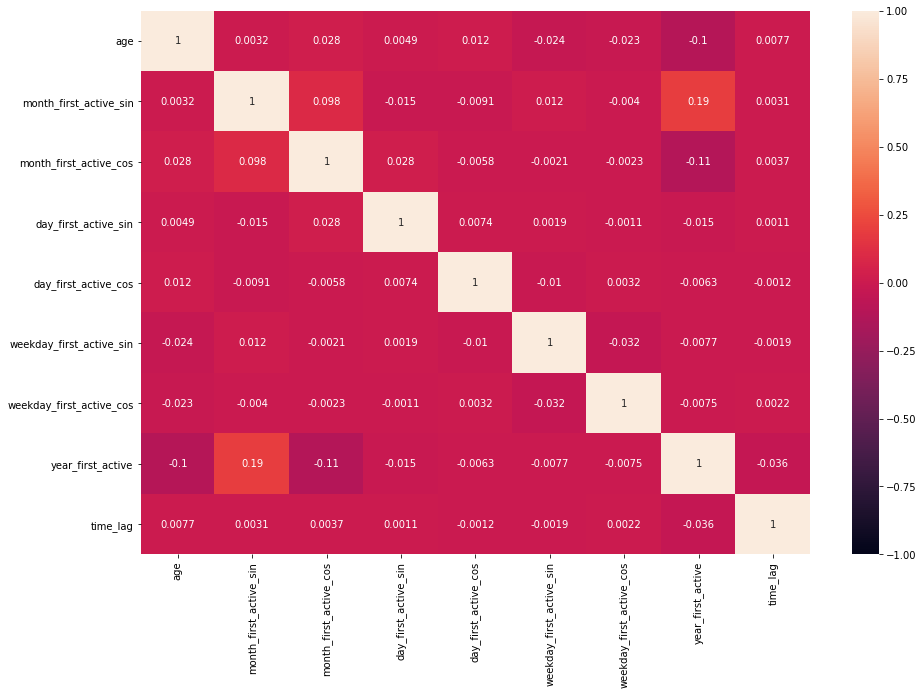

In [0]:
#sn.set(font_scale=1.4)
plt.figure(figsize=(15,10))
sns.heatmap(data_corr.corr(), annot=True, vmax = 1, vmin = -1)
plt.show()

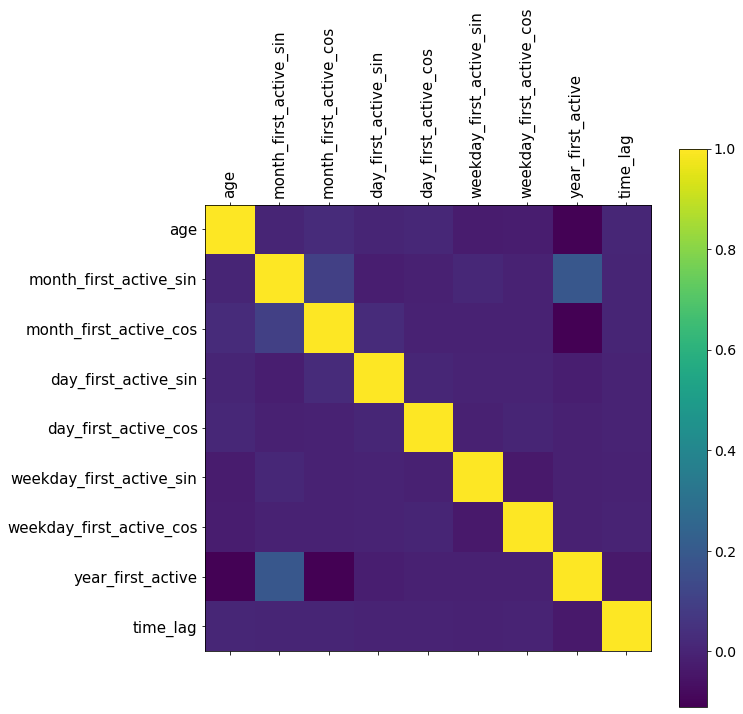

In [0]:
f = plt.figure(figsize=(10, 10))
plt.matshow(data_corr.corr(), fignum=f.number)
plt.xticks(range(data_corr.shape[1]), data_corr.columns, fontsize=15, rotation=90)
plt.yticks(range(data_corr.shape[1]), data_corr.columns, fontsize=15)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [0]:
standardize(data, ["year_first_active", "time_lag", "day_first_active", "weekday_first_active", "month_first_active"])

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,day_first_active,weekday_first_active,month_first_active,year_first_active,time_lag,month_first_active_sin,month_first_active_cos,day_first_active_sin,day_first_active_cos,weekday_first_active_sin,weekday_first_active_cos
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,0.347279,0.115325,-1.158200,-4.603539,44.307172,0.866025,5.000000e-01,-0.485302,-0.874347,0.974928,-0.222521
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,0.163287,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,0.804052,1.142290,-0.488226,-4.603539,69.537221,0.866025,-5.000000e-01,-0.968077,-0.250653,-0.433884,-0.900969
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,1.702840,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,-0.794653,-0.911641,-0.153239,-4.603539,45.183726,0.500000,-8.660254e-01,0.998717,-0.050649,0.000000,1.000000
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,0.505410,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,1.717599,1.142290,1.186710,-4.603539,72.720420,-1.000000,-1.836970e-16,-0.201299,0.979530,-0.433884,-0.900969
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,0.419879,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,-0.908847,-0.911641,1.856684,-4.603539,26.621924,-0.500000,8.660254e-01,0.988468,0.151428,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,cv0na2lf5a,2014-09-30,2014-09-30 23:52:32,-unknown-,-0.435428,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NaN,1.603405,-0.911641,0.851723,0.820888,-0.061335,-0.866025,-5.000000e-01,-0.394356,0.918958,0.000000,1.000000
62092,zp8xfonng8,2014-09-30,2014-09-30 23:53:06,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-,NaN,1.603405,-0.911641,0.851723,0.820888,-0.061372,-0.866025,-5.000000e-01,-0.394356,0.918958,0.000000,1.000000
62093,fa6260ziny,2014-09-30,2014-09-30 23:54:08,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox,NaN,1.603405,-0.911641,0.851723,0.820888,-0.061441,-0.866025,-5.000000e-01,-0.394356,0.918958,0.000000,1.000000
62094,87k0fy4ugm,2014-09-30,2014-09-30 23:54:30,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NaN,1.603405,-0.911641,0.851723,0.820888,-0.061465,-0.866025,-5.000000e-01,-0.394356,0.918958,0.000000,1.000000


In [0]:
# Drop colonne duplicate

data.drop(["date_account_created", "timestamp_first_active",
           "day_first_active", "weekday_first_active",
           "month_first_active"], axis = 1, inplace = True)

## Sistemazione valori poco presenti nel dataset

In [0]:
data.columns

Index(['id', 'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'year_first_active', 'time_lag',
       'month_first_active_sin', 'month_first_active_cos',
       'day_first_active_sin', 'day_first_active_cos',
       'weekday_first_active_sin', 'weekday_first_active_cos'],
      dtype='object')

In [0]:
data["signup_method"].value_counts()

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64

In [0]:
data["signup_flow"].value_counts()

0     206092
25     29834
12     11244
3       8822
2       6881
23      6408
24      4328
1       1047
8        315
6        301
21       197
5         36
20        14
16        11
15        10
14         4
10         2
4          1
Name: signup_flow, dtype: int64

In [0]:
data["language"].value_counts()

en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
pl               75
da               75
no               51
cs               49
el               30
th               28
hu               25
id               23
fi               20
ca                6
is                5
hr                2
-unknown-         1
Name: language, dtype: int64

In [0]:
data["first_affiliate_tracked"].value_counts()

untracked        143181
linked            62064
omg               54859
tracked-other      6655
product            2353
marketing           281
local ops            69
Name: first_affiliate_tracked, dtype: int64

In [0]:
data["signup_app"].value_counts()

Web        219918
iOS         34593
Android     10519
Moweb       10517
Name: signup_app, dtype: int64

In [0]:
data["first_device_type"].value_counts()

Mac Desktop           106328
Windows Desktop        86948
iPhone                 39814
iPad                   18036
Other/Unknown          11167
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
SmartPhone (Other)       191
Name: first_device_type, dtype: int64

In [0]:
data["first_browser"].value_counts()

Chrome                  78671
Safari                  53302
-unknown-               44394
Firefox                 38665
Mobile Safari           29636
IE                      24744
Chrome Mobile            3186
Android Browser          1577
AOL Explorer              254
Opera                     228
Silk                      172
IE Mobile                 118
BlackBerry Browser         89
Chromium                   83
Mobile Firefox             64
Maxthon                    60
Apple Mail                 45
Sogou Explorer             43
SiteKiosk                  27
RockMelt                   24
Iron                       24
IceWeasel                  14
Yandex.Browser             14
Pale Moon                  13
CometBird                  12
SeaMonkey                  12
Camino                      9
TenFourFox                  8
Opera Mini                  8
wOSBrowser                  7
CoolNovo                    6
Opera Mobile                4
Avant Browser               4
Mozilla   

In [0]:
# Alcuni valori pochi presenti nel dataset vengono cambiati in "other"

data["language"] = data["language"].replace(data["language"].value_counts()[data["language"].value_counts() < 10].index.to_list(), "other")

data["first_browser"] = data["first_browser"].replace(data["first_browser"].value_counts()[data["first_browser"].value_counts() < 60].index.to_list(), "other")

data["affiliate_provider"] = data["affiliate_provider"].replace(data["affiliate_provider"].value_counts()[data["affiliate_provider"].value_counts() < 100].index.to_list(), "other")

## Sessions Information

In [0]:
sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [0]:
sessions.rename(columns = {'user_id': 'id'}, inplace=True)

In [0]:
sessions.head()

,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [0]:
sessions["action_type"].value_counts()

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [0]:
sessions["action_detail"].value_counts()

view_search_results         1776885
p3                          1376550
-unknown-                   1031141
wishlist_content_update      706824
user_profile                 656839
                             ...   
special_offer_field               3
host_refund_guest                 2
tos_2014                          2
host_respond_page                 2
host_standard_suspension          1
Name: action_detail, Length: 155, dtype: int64

In [0]:
sessions["device_type"].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [0]:
sessions["action"] = sessions["action"].replace(sessions["action"].value_counts()[sessions["action"].value_counts() < 1000].index.to_list(), "other")

sessions["action_detail"] = sessions["action_detail"].replace(sessions["action_detail"].value_counts()[sessions["action_detail"].value_counts() < 1000].index.to_list(), "other")

In [0]:
sessions.head()

,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [0]:
action_count = sessions.groupby(['id', 'action'])['secs_elapsed'].count().unstack()
action_type_count = sessions.groupby(['id', 'action_type'])['secs_elapsed'].count().unstack()
action_detail_count = sessions.groupby(['id', 'action_detail'])['secs_elapsed'].count().unstack()
device_type_sum = sessions.groupby(['id', 'device_type'])['secs_elapsed'].sum().unstack()

sessions_data = pd.concat([action_count, action_type_count, action_detail_count, device_type_sum], axis=1)
sessions_data.columns = sessions_data.columns.map(lambda x: str(x) + '_count')


#Standardize and join
sessions_data = (sessions_data - sessions_data.mean()) / sessions_data.std()


# Device più usato
sessions_data['most_used_device'] = sessions.groupby('id')['device_type'].max()

data = data.join(sessions_data, on='id')

In [0]:
# Calcolo di diverse feature su "secs_elapsed"

a = sessions.groupby('id')['secs_elapsed'].agg(
    
        secs_elapsed_sum = np.sum,
        secs_elapsed_mean = np.mean,
        secs_elapsed_min = np.min,
        secs_elapsed_max = np.max,
        secs_elapsed_median = np.median,
        secs_elapsed_std = np.std,
        day_pauses = lambda x: (x > 86400).sum(),
        long_pauses = lambda x: (x > 300000).sum(),
        short_pauses = lambda x: (x < 3600).sum(),
        session_length = np.count_nonzero
)

a["secs_elapsed_skew"] = sessions.groupby("id")["secs_elapsed"].skew()
# Standardize
a = (a - a.mean()) / a.std()

In [0]:
data = data.join(a, on='id')

In [0]:
categorical_features = [
    'gender', 'signup_method', 'signup_flow', 'language',
    'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
    'signup_app', 'first_device_type', 'first_browser', 'most_used_device'
]
data = pd.get_dummies(data, columns=categorical_features)

In [0]:
data.fillna(-99, inplace = True)

In [0]:
# salvo csv sistemato
#data.to_csv("/content/drive/My Drive/progetto_aml/dataset/train_prepocessed.csv" ,index = False)

#XGBOOST

In [0]:
data = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/train_prepocessed.csv")

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train, X_test = train_test_split(data_prova, test_size = 0.2, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)

In [0]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
X_train=pca.transform(X_train)
X_test=pca.transform(X_test)

In [0]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
xgb = XGBClassifier(max_depth=7, learning_rate=0.18, n_estimators=100,
                    objective='multi:softprob', colsample_bytree=1, 
                    seed=42, n_jobs = -1, tree_method = "gpu_hist", max_delta_step = 1)

In [0]:
xgb.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)], 
        eval_metric = "mlogloss",
        early_stopping_rounds=3)

[0]	validation_0-mlogloss:2.29866	validation_1-mlogloss:2.30065
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 3 rounds.
[1]	validation_0-mlogloss:2.12371	validation_1-mlogloss:2.12787
[2]	validation_0-mlogloss:1.96113	validation_1-mlogloss:1.9673
[3]	validation_0-mlogloss:1.81318	validation_1-mlogloss:1.82175
[4]	validation_0-mlogloss:1.68239	validation_1-mlogloss:1.69331
[5]	validation_0-mlogloss:1.5685	validation_1-mlogloss:1.58192
[6]	validation_0-mlogloss:1.47119	validation_1-mlogloss:1.48705
[7]	validation_0-mlogloss:1.38958	validation_1-mlogloss:1.40802
[8]	validation_0-mlogloss:1.32337	validation_1-mlogloss:1.34426
[9]	validation_0-mlogloss:1.26976	validation_1-mlogloss:1.29312
[10]	validation_0-mlogloss:1.226	validation_1-mlogloss:1.25184
[11]	validation_0-mlogloss:1.18986	validation_1-mlogloss:1.21826
[12]	validation_0-mlogloss:1.1596	validation_1-mlogloss:1.19063
[13]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.18, max_delta_step=1, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

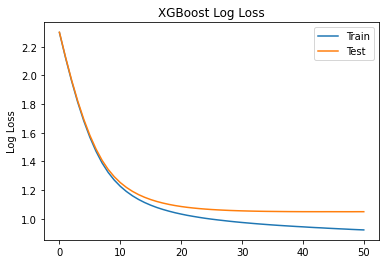

In [0]:
results = xgb.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [0]:
y_pred_prob = xgb.predict_proba(X_test)

In [0]:
# FEATURES CICLICHE
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.8277235540430934

In [0]:
# NO CICLICHE
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.8318565591965077

In [0]:
# CICLICHE STANDARDIZZATE
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.8314509333017616

# Prova di feature importance, però non serve a molto in realtà (come se non ci fosse)

In [0]:
data = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/train_prepocessed.csv")

In [0]:
# Funzioni per calcolare ndcg

def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) ))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)



ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train, X_test = train_test_split(data_prova, test_size = 0.2, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
xgb = XGBClassifier(max_depth=7, learning_rate=0.18, n_estimators=100,
                    objective='multi:softprob',# colsample_bytree=0.6, subsample = 0.7, 
                    seed=42, n_jobs = -1, max_delta_step = 1, tree_method = "gpu_hist")

In [0]:
xgb.fit(X_train.values, y_train, 
        eval_set = [(X_train.values, y_train), (X_test.values, y_test)], 
        eval_metric = "mlogloss",
        early_stopping_rounds=10)

ValueError: ignored

In [0]:
y_pred_prob = xgb.predict_proba(X_test.values)

In [0]:
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.831531251645954

In [0]:
top_n_accuracy(encoded_y_test, y_pred_prob)

0.9587735119814481

In [0]:
import operator
importance = xgb.get_booster().get_fscore()
importance_df = pd.DataFrame(
    sorted(importance.items(), key=operator.itemgetter(1)),
    columns=['feature', 'fscore']
)

In [0]:
importance_df = importance_df.iloc[-20:, :]

<Figure size 432x288 with 0 Axes>

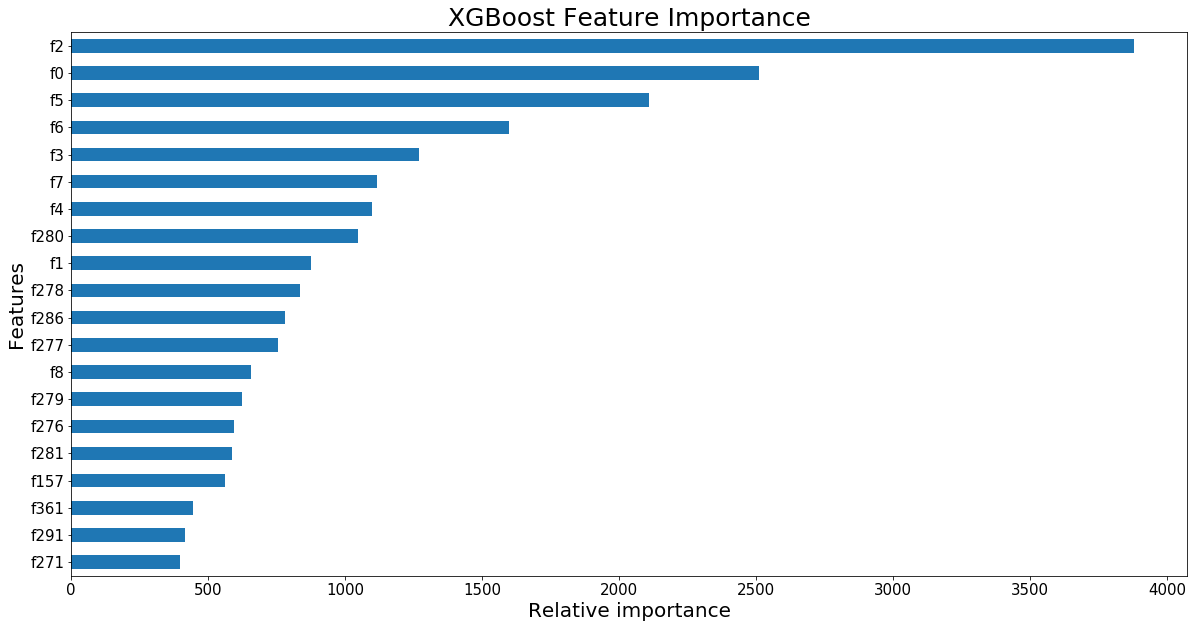

In [0]:
plt.figure()
importance_df.plot(kind='barh', x='feature', y='fscore',
                   legend=False, figsize=(20, 10))
plt.title('XGBoost Feature Importance', size=25)
plt.xlabel('Relative importance', size=20)
plt.ylabel('Features', size=20)
plt.tick_params(labelsize=15)

In [0]:
features = list(importance_df.feature.str.replace("f", "").astype("int").values)

In [0]:
data = pd.read_csv('/content/drive/My Drive/progetto_aml/dataset/train_users_2.csv')
test = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/test_users.csv")
sessions = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/sessions.csv")

In [0]:
train_row = data.shape[0]

In [0]:
data = data.append(test)

In [0]:
train = data[:train_row]
test = data[train_row:]

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train, X_test = train_test_split(train, test_size = 0.2, stratify = train["country_destination"], random_state = 42)

In [0]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
xgb = XGBClassifier(max_depth=7, learning_rate=0.18, n_estimators=100,
                    objective='multi:softprob', colsample_bytree=1, 
                    seed=42, n_jobs = -1, tree_method = "gpu_hist", max_delta_step = 1)

In [0]:
xgb.fit(X_train.values, y_train, 
        eval_set = [(X_train.values, y_train), (X_test.values, y_test)], 
        eval_metric = "mlogloss",
        early_stopping_rounds=3)

[0]	validation_0-mlogloss:2.2987	validation_1-mlogloss:2.30001
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 3 rounds.
[1]	validation_0-mlogloss:2.12365	validation_1-mlogloss:2.12616
[2]	validation_0-mlogloss:1.96193	validation_1-mlogloss:1.96566
[3]	validation_0-mlogloss:1.81378	validation_1-mlogloss:1.81919
[4]	validation_0-mlogloss:1.6803	validation_1-mlogloss:1.68741
[5]	validation_0-mlogloss:1.56481	validation_1-mlogloss:1.57363
[6]	validation_0-mlogloss:1.46648	validation_1-mlogloss:1.47687
[7]	validation_0-mlogloss:1.38363	validation_1-mlogloss:1.39562
[8]	validation_0-mlogloss:1.31686	validation_1-mlogloss:1.33049
[9]	validation_0-mlogloss:1.26327	validation_1-mlogloss:1.27853
[10]	validation_0-mlogloss:1.21969	validation_1-mlogloss:1.23656
[11]	validation_0-mlogloss:1.18396	validation_1-mlogloss:1.2024
[12]	validation_0-mlogloss:1.15424	validation_1-mlogloss:1.17423
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.18, max_delta_step=1, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

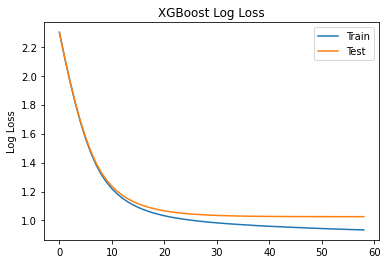

In [0]:
results = xgb.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [0]:
y_pred_prob = xgb.predict_proba(X_test.values)

In [0]:
# FEATURES CICLICHE
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.831109160709012

In [0]:
id_test = test.pop("id")

In [0]:
test.pop("country_destination")

In [0]:
prob_test = xgb.predict_proba(test.values)

In [0]:
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(prob_test[i])[::-1])[:5].tolist()

In [0]:
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

In [0]:
sub.to_csv("sub.csv", index=False)